# Ladder Networks

## References:  
[1] original (Gaussian) denoising function - called here Curious AI combinator  
Rasmus, Antti et al.: "Semi-Supervised Learning with Ladder Networks" - http://arxiv.org/pdf/1507.02672v2.pdf  
[2] "vanilla" denoising function - called here MILA UDEM combinator  
    Pezeshki,  et al.: "Deconstructing the Ladder Network Architecture" - http://arxiv.org/pdf/1511.06430.pdf  
[3] for a deeper dive into theory behind:  
    Valpola, Harri: "From Neural PCA to Deep Unsupervised Learning" - http://arxiv.org/pdf/1411.7783.pdf 

## Bit of description

In [2]:
from PIL import Image

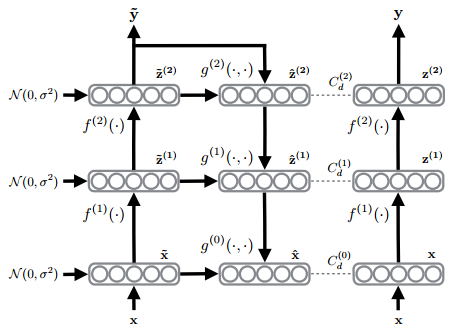

In [3]:
Image.open('./ladder_net_arch.png') # the ladder net architecture diagram from [1]

Ladder net building blocks:
    * dirty encoder - the most left, built first
    * clean encoder - the most right, built second, sharing weights and BN params of the dirty one 
    * decoder - the middle one, built on top of the dirty encoder, sharing its transposed weights
    * batch normalization divided between normalization part (mean, inv_std) and learning part (beta, gamma)
    * Gaussian noise injection in between the batchnorm parts in the dirty encode  
    * ReLUs (no gamma needed to learn in BN) used in encoder's latent layers, softmax as a classifier
    * denoising (combinator) function g used as a nonlinearity in the decoder (instance of Merge layer):
        1. used in Curious AI paper:
$$ \hat{z} = g(\tilde{z}, u) = (\tilde{z} - \mu(u)) \odot \sigma(u) + \mu(u) $$
$$ \mu(u) = w_0 \odot \text{sigmoid}(w_2 \odot u + b_0) + w_3 \odot u + b_1 $$
$$ \sigma(u) = w_4 \odot \text{sigmoid}(w_5 \odot u + b_2) + w_6 \odot u + b_3 $$
        2. used in MILA UDEM paper:
$$ g(\tilde{z}(l), u(l+1)) = b_0 + w_0^z \odot \tilde{z}(l) + w_0^u \odot u(l+1) + w_0^{zu} \odot \tilde{z}(l) \odot u(l+1) + \\
w^\sigma \odot \text{sigmoid}(b_1 + w_1^z \odot \tilde{z}(l) + w_1^u \odot u(l+1) + w_1^{zu} \odot \tilde{z}(l) \cdot u(l+1)) $$ 
$$ \mu(u) = w_0 \odot \text{sigmoid}(w_2 \odot u + b_0) + w_3 \odot u + b_1 $$
$$ \sigma(u) = w_4 \odot \text{sigmoid}(w_5 \odot u + b_2) + w_6 \odot u + b_3 $$
Cost terms:
    * classification cost
    * reconstruction cost(s)
$$ \text{Cost} = - \sum\limits^N_{n=1} \log P\left(\tilde{y}(n) = t(n)|x(n) \right) - \sum\limits^L_{l=0} \lambda_l \sum\limits^N_{n=1} \| z^{(l)}(n) - \tilde{z}^{(l)}_{BN}(n) \|^2 $$

## Implementation

In [ ]:
# %load ladder_nets.py
from lasagne.layers import InputLayer, MergeLayer, DenseLayer, DropoutLayer, \
    GaussianNoiseLayer, NonlinearityLayer
from lasagne.layers.normalization import BatchNormLayer
from lasagne.nonlinearities import *
import lasagne

import theano
import theano.tensor as T

import numpy as np
from collections import OrderedDict


def _create_milaUDEM_params(shape, name):
    values = np.zeros((6,) + shape, dtype=theano.config.floatX)

    b_lin = theano.shared(values[0],
                               name='bias_lin_{}'.format(name))
    b_sigm = theano.shared(values[1],
                                name='bias_sigm_{}'.format(name))

    w_u_lin = theano.shared(values[2],
                                 name='weight_u_lin_{}'.format(name))
    w_u_sigm = theano.shared(values[3],
                                  name='weight_u_sigm_{}'.format(name))
    w_zu_lin = theano.shared(values[4],
                                  name='weight_zu_lin_{}'.format(name))
    w_zu_sigm = theano.shared(values[5],
                                   name='weight_zu_sigm_{}'.format(name))

    values = np.ones((3,) + shape, dtype=theano.config.floatX)
    w_z_lin = theano.shared(values[0],
                                 name='weight_z_lin_{}'.format(name))
    w_z_sigm = theano.shared(values[1],
                                  name='weight_z_sigm_{}'.format(name))
    w_sigm = theano.shared(values[2],
                                name='weight_sigm_{}'.format(name))

    # combinator params used in combinator calculations
    return [w_u_lin, w_z_lin, w_zu_lin, w_u_sigm, w_z_sigm,
            w_zu_sigm, w_sigm, b_lin, b_sigm]


def _create_curiousAI_params(shape, name):
    values = np.zeros((8,) + shape, dtype=theano.config.floatX)

    b_mu_sig = theano.shared(values[0],
                                  name='b_mu_sig_{}'.format(name))
    b_mu_lin = theano.shared(values[1],
                                  name='b_mu_lin_{}'.format(name))
    b_v_sig = theano.shared(values[2],
                                 name='b_v_sig_{}'.format(name))
    b_v_lin = theano.shared(values[3],
                                 name='b_v_lin_{}'.format(name))

    w_mu_lin = theano.shared(values[4],
                                  name='w_mu_lin_{}'.format(name))
    w_v_lin = theano.shared(values[5],
                                  name='w_v_lin_{}'.format(name))
    w_mu = theano.shared(values[6],
                              name='w_mu_{}'.format(name))
    w_v = theano.shared(values[7],
                             name='w_v_{}'.format(name))

    values = np.ones((2,) + shape, dtype=theano.config.floatX)
    w_mu_sig = theano.shared(values[0],
                                  name='w_mu_sig_{}'.format(name))
    w_v_sig = theano.shared(values[1],
                                 name='w_v_sig_{}'.format(name))

    # combinator params used in combinator calculations
    return [w_mu_lin, w_v_lin, w_mu_sig, w_v_sig, w_mu, w_v,
            b_mu_lin, b_v_lin, b_mu_sig, b_v_sig]


def _create_combinator_params(combinator_type, shape, name):
    if combinator_type == 'milaUDEM':
        return _create_milaUDEM_params(shape, name)
    elif combinator_type == 'curiousAI':
        return _create_curiousAI_params(shape, name)


def _combinator_MILAudem(z, u, combinator_params, bc_pttrn):
    w_u_lin, w_z_lin, w_zu_lin, w_u_sigm, w_z_sigm, w_zu_sigm, w_sigm, \
                                b_lin, b_sigm = combinator_params

    lin_out = w_z_lin.dimshuffle(*bc_pttrn) * z + \
              w_u_lin.dimshuffle(*bc_pttrn) * u + \
              w_zu_lin.dimshuffle(*bc_pttrn) * z * u + \
              b_lin.dimshuffle(*bc_pttrn)
                
    sigm_pre = w_z_sigm.dimshuffle(*bc_pttrn) * z + \
               w_u_sigm.dimshuffle(*bc_pttrn) * u + \
               w_zu_sigm.dimshuffle(*bc_pttrn) * z * u + \
               b_sigm.dimshuffle(*bc_pttrn)
    
    sigm_out = T.nnet.sigmoid(sigm_pre)
    
    output = w_sigm.dimshuffle(*bc_pttrn) * sigm_out + lin_out

    return output


def _combinator_curiousAI(z, u, combinator_params, bc_pttrn):
    w_mu_lin, w_v_lin, w_mu_sig, w_v_sig, w_mu, w_v, \
    b_mu_lin, b_v_lin, b_mu_sig, b_v_sig = combinator_params

    mu_sig_pre = w_mu_sig.dimshuffle(*bc_pttrn) * u + \
                 b_mu_sig.dimshuffle(*bc_pttrn)

    mu_lin_out = w_mu_lin.dimshuffle(*bc_pttrn) * u + \
                 b_mu_lin.dimshuffle(*bc_pttrn)

    mu_u = w_mu.dimshuffle(*bc_pttrn) * T.nnet.sigmoid(mu_sig_pre) + \
           mu_lin_out

    v_sig_pre = w_v_sig.dimshuffle(*bc_pttrn) * u + \
                b_v_sig.dimshuffle(*bc_pttrn)
        
    v_lin_out = w_v_lin.dimshuffle(*bc_pttrn) * u + \
                b_v_lin.dimshuffle(*bc_pttrn)

    v_u = w_v * T.nnet.sigmoid(v_sig_pre) + v_lin_out

    output = (z - mu_u) * v_u + mu_u

    return output


def _combinator(z, u, combinator_type, combinator_params):
    if u.ndim == 2:
        bc_pttrn = ('x', 0)
    elif u.ndim == 4:
        bc_pttrn = ('x', 0, 'x', 'x')
    
    if combinator_type == 'milaUDEM':
        return _combinator_MILAudem(z, u, combinator_params, bc_pttrn)
    elif combinator_type == 'curiousAI':
        return _combinator_curiousAI(z, u, combinator_params, bc_pttrn)


class CombinatorLayer(MergeLayer):
    """
        A layer that combines the terms from dirty and clean encoders,
        and outputs denoised variable:
            $$ \hat{z} = g(\tilde{z}, u)$$
    """
    def __init__(self, incoming_z, incoming_u, combinator_type, **kwargs):
        super(CombinatorLayer, self).__init__(
            [incoming_z, incoming_u], **kwargs)
        self.combinator_type = combinator_type
        z_shp, u_shp = self.input_shapes

        if len(z_shp) != len(u_shp):
            raise ValueError("The inputs must have the same shape: "
                             "(batch_size, num_hidden) in case of dense layer or \n"
                             "(batch_size, num_feature_maps, height, width) "
                             "in case of conv layer.")

        self.combinator_params = _create_combinator_params(combinator_type, 
                                                           u_shp[1:],
                                                           self.name)

    def get_output_shape_for(self, input_shapes):
        return input_shapes[0]

    def get_output_for(self, inputs, **kwargs):
        z, u = inputs
        assert z.ndim == u.ndim
        return _combinator(z, u, self.combinator_type, self.combinator_params)


def build_encoder(net, num_hidden, activation, name,
                  p_drop_hidden=0., shared_net=None):
    for i, num_nodes in enumerate(num_hidden):
        dense_lname = 'enc_dense_{}'.format(i)
        nbatchn_lname = 'enc_batchn_{}_norm'.format(i)
        noise_lname = 'enc_noise_{}'.format(i)
        lbatchn_lname = 'enc_batchn_{}_learn'.format(i)

        if shared_net is None:
            # dense pars
            W = lasagne.init.GlorotUniform()
            # batchnorm pars
            beta = lasagne.init.Constant(0)
            gamma = None if activation == rectify else lasagne.init.Constant(1)
        else:
            # dense pars
            W = shared_net[dense_lname].get_params()[0]
            # batchnorm pars
            if activation==rectify:
                beta = shared_net[lbatchn_lname].get_params()[0]
                gamma = None
            else:
                beta, gamma = shared_net[lbatchn_lname].get_params()

        net[dense_lname] = DenseLayer(net.values()[-1], num_units=num_nodes, W=W,
                                      nonlinearity=linear,
                                      name='{}_{}'.format(name, dense_lname))

        shp = net[dense_lname].output_shape[1]
        zero_const = T.zeros(shp, np.float32)
        one_const = T.ones(shp, np.float32)

        # 1. batchnormalize without learning -> goes to combinator layer
        l_name = '{}_{}'.format(name, nbatchn_lname)
        net[nbatchn_lname] = BatchNormLayer(net.values()[-1], alpha=0.1,
                                            beta=None, gamma=None, name=l_name)

        if shared_net is None:
            # add noise in dirty encoder
            net[noise_lname] = GaussianNoiseLayer(net.values()[-1],
                                                  sigma=p_drop_hidden,
                                                  name='{}_{}_'.format(name,
                                                                       noise_lname))

        # 2. batchnormalization learning, 
        # alpha set to one in order to depenend only on the given batch mean and inv_std
        l_name = '{}_{}'.format(name, lbatchn_lname)
        net[lbatchn_lname] = BatchNormLayer(net.values()[-1], alpha=1.,
                                            beta=beta, gamma=gamma, name=l_name,
                                            mean=zero_const, inv_std=one_const)

        if i < len(num_hidden) - 1:
            act_name = 'enc_activation_{}'.format(i)
            net[act_name] = NonlinearityLayer(net.values()[-1],
                                              nonlinearity=activation,
                                              name='{}_{}'.format(name, act_name))

    net['enc_softmax'] = NonlinearityLayer(net.values()[-1], nonlinearity=softmax,
                                           name='{}_enc_softmax'.format(name))

    return net['enc_softmax'], net


def build_decoder(dirty_net, clean_net, num_nodes, sigma,
                  combinator_type='milaUDEM'):
    L = len(num_nodes) - 1

    # dirty_enc_dense_1 ... z_L
    z_L = dirty_net['enc_noise_{}'.format(L)]
    
    # batchnormalized softmax output .. u_0 without learning bn beta, gamma
    dirty_net['u_0'] = BatchNormLayer(dirty_net.values()[-1], beta=None,
                                      gamma=None, name='dec_batchn_softmax')
    
    # denoised latent \hat{z}_L = g(\tilde{z}_L, u_L)
    comb_name = 'dec_combinator_0'
    dirty_net[comb_name] = CombinatorLayer(*[z_L, dirty_net['u_0']],
                                           combinator_type=combinator_type,
                                           name=comb_name)
    
    # batchnormalize denoised latent using clean encoder's bn mean/inv_std without learning
    enc_bname = 'enc_batchn_{}_norm'.format(L)
    mu, inv_std = clean_net[enc_bname].get_params()
    bname = 'dec_batchn_0'
    dirty_net[bname] = BatchNormLayer(dirty_net.values()[-1], alpha=1.,
                                      beta=None, gamma=None, name=bname,
                                      mean=mu, inv_std=inv_std)

    for i in range(L):
        # dirty_enc_dense_L-i ... z_l
        z_l = dirty_net['enc_noise_{}'.format(i)]
        
        # affine transformation
        d_name = 'dec_dense_{}'.format(L-i)
        dirty_net[d_name] = DenseLayer(dirty_net.values()[-1],
                                       num_units=num_nodes[i],
                                       nonlinearity=linear, name=d_name)
        
        # batchnormalization ... u_l
        dirty_net['u_l'] = BatchNormLayer(dirty_net.values()[-1], beta=None,
                                          gamma=None,
                                          name='dec_batchn_dense_{}'.format(L-i))
        
        # denoised latent \hat{z}_L-i
        comb_name = 'dec_combinator_{}'.format(i+1)
        dirty_net[comb_name] = CombinatorLayer(*[z_l, dirty_net['u_l']],
                                               combinator_type=combinator_type,
                                               name=comb_name)
        
        # batchnormalized latent \hat{z}_L-i^{BN}
        enc_bname = 'enc_batchn_{}_norm'.format(L-i-1)
        mu, inv_std = clean_net[enc_bname].get_params()
        bname = 'dec_batchn_{}'.format(L-i)
        dirty_net[bname] = BatchNormLayer(dirty_net.values()[-1], alpha=1.,
                                          beta=None, gamma=None, name=bname,
                                          mean=mu, inv_std=inv_std)
        
    # corrupted input ... z_0
    z_0 = dirty_net['inp_corr']

    # affine transformation
    d_name = 'dec_dense_{}'.format(L+1)
    dirty_net[d_name] = DenseLayer(dirty_net.values()[-1], nonlinearity=linear,
                                   num_units=num_nodes[i+1], name=d_name)
    
    # batchnormalization ... u_L
    dirty_net['u_L'] = BatchNormLayer(dirty_net.values()[-1], beta=None, gamma=None)
    
    # denoised input reconstruction
    comb_name = 'dec_combinator_{}'.format(L+1)
    dirty_net[comb_name] = CombinatorLayer(*[z_0, dirty_net['u_L']], name=comb_name,
                                           combinator_type=combinator_type)

    return dirty_net


def build_model(num_encoder, num_decoder, p_drop_input, p_drop_hidden,
                activation=rectify, batch_size=None, inp_size=None,
                combinator_type='MILAudem'):
    net = OrderedDict()
    net['input'] = InputLayer((batch_size, inp_size), name='input')
    # corrupted input
    net['inp_corr'] = GaussianNoiseLayer(net['input'], sigma=p_drop_input,
                                         name='input_corr')

    # dirty encoder
    train_output_l, dirty_encoder = build_encoder(net, num_encoder, activation,
                                                  'dirty', p_drop_hidden)

    # clean encoder
    clean_net = OrderedDict(net.items()[:1])
    eval_output_l, clean_net = build_encoder(clean_net, num_encoder, activation,
                                             'clean', 0., shared_net=dirty_encoder)

    # dirty decoder
    dirty_net = build_decoder(dirty_encoder, clean_net, num_decoder,
                              p_drop_hidden, combinator_type)

    return [train_output_l, eval_output_l], dirty_net, clean_net


def build_cost(X, y, num_decoder, dirty_net, clean_net, output_train, lambdas):
    class_cost = T.nnet.categorical_crossentropy(T.clip(output_train, 1e-15, 1),
                                                 y).mean()
    L = len(num_decoder)
    
    # get clean and corresponding dirty latent layer output
    z_clean_l = clean_net['input']
    z_dirty_l = dirty_net['dec_combinator_{}'.format(L)]
    
    z_clean = lasagne.layers.get_output(z_clean_l, X, deterministic=False)
    z_dirty = lasagne.layers.get_output(z_dirty_l, X, deterministic=False)

    # squared error
    rec_costs = [lambdas[L] * T.sqr(z_clean - z_dirty).mean()]

    for l in range(L):
        z_clean_l = clean_net['enc_batchn_{}_norm'.format(l)]
        z_dirty_l = dirty_net['dec_batchn_{}'.format(L-l-1)]

        z_clean = lasagne.layers.get_output(z_clean_l, X, deterministic=False)
        z_dirty = lasagne.layers.get_output(z_dirty_l, X, deterministic=False)

        rec_costs.append(lambdas[l] * T.sqr(z_clean - z_dirty).mean())

    return class_cost, rec_costs

In [ ]:
# %load utils.py
import gzip
import cPickle as pickle
import sys

def pickle_load(f, encoding):
    return pickle.load(f)

def load_data():
    """Get data with labels, split into training, validation and test set."""
    with gzip.open('mnist.pkl.gz', 'rb') as f:
        data = pickle_load(f, encoding='latin-1')
    X_train, y_train = data[0]
    X_valid, y_valid = data[1]
    X_test, y_test = data[2]

    return dict(
        X_train=theano.shared(lasagne.utils.floatX(X_train)),
        y_train=T.cast(theano.shared(y_train), 'int32'),
        X_valid=theano.shared(lasagne.utils.floatX(X_valid)),
        y_valid=T.cast(theano.shared(y_valid), 'int32'),
        X_test=theano.shared(lasagne.utils.floatX(X_test)),
        y_test=T.cast(theano.shared(y_test), 'int32'),
        num_examples_train=X_train.shape[0],
        num_examples_valid=X_valid.shape[0],
        num_examples_test=X_test.shape[0],
        input_dim=X_train.shape[1],
        output_dim=10,
    )

In [3]:
!wget -N http://deeplearning.net/data/mnist/mnist.pkl.gz

--2016-06-21 12:04:46--  http://deeplearning.net/data/mnist/mnist.pkl.gz
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16168813 (15M) [application/x-gzip]
Saving to: 'mnist.pkl.gz.1'

100%[======================================>] 16,168,813  4.61MB/s   in 3.3s   

2016-06-21 12:04:54 (4.61 MB/s) - 'mnist.pkl.gz.1' saved [16168813/16168813]



In [22]:
# %load train_ladder_nets.py

import time
import theano.misc.pkl_utils

LEARNING_RATE = 0.1
LR_DECREASE = 1.
BATCH_SIZE = 100
NUM_EPOCHS = 15
COMBINATOR_TYPE = 'milaUDEM'
LAMBDAS = [0.1, 0.1, 0.1]
DROPOUT = 0.3

print "Loading data..."
dataset = load_data()

# build network
num_encoder = [500, 10]
num_decoder = [500, 784]

print "Building model and compiling functions..."
[train_output_l, eval_output_l], dirty_net, clean_net = build_model(
    num_encoder, num_decoder, DROPOUT, DROPOUT, batch_size=None, 
    inp_size=784, combinator_type=COMBINATOR_TYPE)

# set up input/output variables
X = T.fmatrix('X')
y = T.ivector('y')

# training output
output_train = lasagne.layers.get_output(train_output_l, X, deterministic=False)

# evaluation output. Also includes output of transform for plotting
output_eval = lasagne.layers.get_output(eval_output_l, X, deterministic=True)

# set up (possibly amortizable) lr, cost and updates
sh_lr = theano.shared(lasagne.utils.floatX(LEARNING_RATE))

class_cost, rec_costs = build_cost(X, lasagne.utils.one_hot(y), num_decoder, 
                                   dirty_net, clean_net, output_train, LAMBDAS)
cost = class_cost + T.sum(rec_costs)

net_params = lasagne.layers.get_all_params(train_output_l, trainable=True)
updates = lasagne.updates.adam(cost, net_params, learning_rate=sh_lr)

# get training and evaluation functions, cost = class_cost + T.sum(rec_costs)
batch_index = T.iscalar('batch_index')
batch_slice = slice(batch_index * BATCH_SIZE, (batch_index + 1) * BATCH_SIZE)

pred = T.argmax(output_eval, axis=1)
accuracy = T.mean(T.eq(pred, y), dtype=theano.config.floatX)

train = theano.function([batch_index], [cost] + rec_costs,
                        updates=updates, givens={
                            X: dataset['X_train'][batch_slice],
                            y: dataset['y_train'][batch_slice],
                        })

eval = theano.function([batch_index], [cost, accuracy], givens={
                           X: dataset['X_valid'][batch_slice],
                           y: dataset['y_valid'][batch_slice],
                       })

# checking for constants in means and inv_stds during training
bl_name = 'enc_batchn_{}_learn'
means = [abs(dirty_net[bl_name.format(i)].mean.ravel()).mean() for i
         in range(len(num_encoder))]
means = T.stack(means, axis=1)
stds = [abs(dirty_net[bl_name.format(i)].inv_std.ravel()).mean() for i
        in range(len(num_encoder))]
stds = T.stack(stds, axis=1)
get_stats = theano.function([], [means, stds])

network_dump = {'train_output_layer': train_output_l,
                'eval_output_layer': eval_output_l,
                'dirty_net': dirty_net,
                'clean_net': clean_net,
                'x': X,
                'y': y,
                'output_eval': output_eval
                }

def save_dump(filename,param_values):
    f = file(filename, 'wb')
    cPickle.dump(param_values,f,protocol=cPickle.HIGHEST_PROTOCOL)
    f.close()


def train_epoch():
    costs = []
    rec_costs = []
    stats = []
    for b in range(num_batches_train):
        train_out = train(b)
        train_cost = train_out[0]
        rec_cost = train_out[1:]

        costs.append(train_cost)
        rec_costs.append(rec_cost)
        stats.append(np.vstack(get_stats()))

    return (np.mean(costs), np.mean(rec_costs, axis=0),
            np.stack(stats, axis=0).mean(axis=0))
    

def eval_epoch():
    costs = []
    accs = []
    preds = []
    targets = []
    for b in range(num_batches_valid):
        eval_cost, eval_acc = eval(b)
        costs.append(eval_cost)
        accs.append(eval_acc)

    return np.mean(eval_cost), np.mean(eval_acc)

num_batches_train = dataset['num_examples_train'] // BATCH_SIZE
num_batches_valid = dataset['num_examples_valid'] // BATCH_SIZE

train_costs, valid_costs, valid_accs = [], [], []

print "Starting training..."
now = time.time()

try:
    for n in range(NUM_EPOCHS):
        train_cost, rec_costs, stats = train_epoch()
        eval_cost, acc = eval_epoch()
        
        train_costs.append(train_cost)
        valid_costs.append(eval_cost)
        valid_accs.append(acc)

        print "Epoch %d took %.3f s" % (n + 1, time.time() - now)
        now = time.time()
        print "Train cost {}, val cost {}, val acc {}".format(train_costs[-1], 
                                                               valid_costs[-1], 
                                                               valid_accs[-1])
        print '\n'.join(['Layer #{} rec cost: {}'.format(i, c) for i, c
                 in enumerate(rec_costs)])
        means, inv_stds = stats
        for i in range(len(num_encoder)):
            print '{}: mean == 0. {}, inv_std == 1. {}'.format(bl_name.format(i),
                                                               np.allclose(means[i], 0.),
                                                               np.allclose(inv_stds[i], 1.))
        
        if (n+1) % 10 == 0:
            new_lr = sh_lr.get_value() * LR_DECREASE
            print "New LR:", new_lr
            sh_lr.set_value(lasagne.utils.floatX(new_lr))
except KeyboardInterrupt:
    pass

# uncomment if to save the learning curve
# save_dump('final_epoch_{}_accs_ladder_net_mnist.pkl'.format(n),
#                   zip(train_cost, valid_cost))

# uncomment if to save the params only
# save_dump('final_epoch_{}_ladder_net_mnist'.format(n),
#           lasagne.layers.get_all_param_values(output_layer))

# uncomment if to save the whole network
# theano.misc.pkl_utils.dump(network_dump,
#                            'final_epoch_{}_ladder_net_mnist.pkl'.format(n))

Loading data...
Building model and compiling functions...
Starting training...
Epoch 1 took 26.439 s
Train cost 0.845667004585, val cost 0.739950656891, val acc 0.949999988079
Layer #0 rec cost: 0.0424115508795
Layer #1 rec cost: 0.0210689622909
Layer #2 rec cost: 0.017903175205
enc_batchn_0_learn: mean == 0. True, inv_std == 1. True
enc_batchn_1_learn: mean == 0. True, inv_std == 1. True
Epoch 2 took 26.815 s
Train cost 0.737154126167, val cost 0.728129386902, val acc 0.949999988079
Layer #0 rec cost: 0.0424207411706
Layer #1 rec cost: 0.0197576656938
Layer #2 rec cost: 0.0171148162335
enc_batchn_0_learn: mean == 0. True, inv_std == 1. True
enc_batchn_1_learn: mean == 0. True, inv_std == 1. True
Epoch 3 took 26.899 s
Train cost 0.708354771137, val cost 0.662552952766, val acc 0.959999978542
Layer #0 rec cost: 0.0424175597727
Layer #1 rec cost: 0.0194249469787
Layer #2 rec cost: 0.0167284980416
enc_batchn_0_learn: mean == 0. True, inv_std == 1. True
enc_batchn_1_learn: mean == 0. True,

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

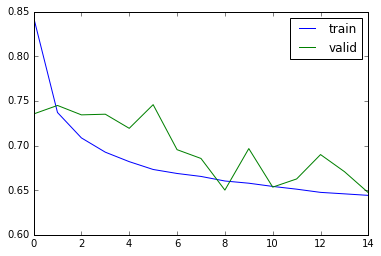

In [11]:
plt.plot(zip(train_costs, valid_costs))
plt.legend(['train', 'valid'])

## Author:  
Adrian Lisko - https://github.com/AdrianLsk